In [ ]:
# this jupyter notebook contains the code used to try the balanced/partially balanced dataset approach

# 1. Setup

In [30]:
!pip install matplotlib
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import models
from keras import regularizers
import math
import os
import pandas as pd

In [31]:
# image parameters
input_height = 69
input_width = 69

# augmentation parameters
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=False

rotation_range=40
width_shift_range=0.2
height_shift_range=0.1
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'

In [ ]:
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=100
batch_size=32
num_classes = 9
regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

In [33]:
# customized metrics for multi class classification

import keras.backend as K
import tensorflow as tf
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = [
    precision,
    recall,
    tf.keras.metrics.CategoricalAccuracy(name='acc')
]

2022-12-29 10:09:07.968462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
paths = {
    'TRAIN_PATH' : os.path.join('workspace', 'images','balanced','train'),
    'TEST_PATH' : os.path.join('workspace', 'images','balanced','test'),
    'EVAL_PATH' : os.path.join('workspace', 'images','balanced','eval'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'ANNOTATION_PATH': os.path.join('workspace','annotations'),
    'ANNOTATION_FILE_PATH': os.path.join('workspace','annotations','annotations.csv'),
    'LOG_DIR' : os.path.join('model', 'log_dir')
 }

In [35]:
# create paths
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 2. Rebalance dataset

In [ ]:
def plotTrainingDistribution():
    files_per_label = dict()
    for i in range(10):
      if i == 5:
        continue
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      files_per_label[i] = n_images
    plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
    plt.show()
    print(files_per_label)

plotTrainingDistribution()

{0: 2488, 1: 5017, 2: 4551, 3: 257, 4: 1122, 6: 415, 7: 797, 8: 645, 9: 380}


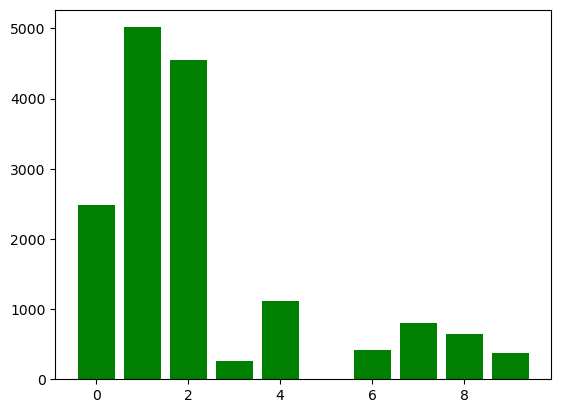

In [17]:
CLASS_TO_DELETE = 5

def remove_images(label):
    annotations = pd.read_csv(paths['ANNOTATION_FILE_PATH'])
    target = annotations[annotations['Class'] == label]
    img_names = list(target['Path'])
    for image in img_names:
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)
      if os.path.exists(os.path.join(paths['TRAIN_PATH'],str(label),image)):
        os.remove(f)

remove_images(CLASS_TO_DELETE)
plotTrainingDistribution()

{0: 2488, 1: 3000, 2: 3000, 3: 257, 4: 1122, 6: 415, 7: 797, 8: 645, 9: 380}


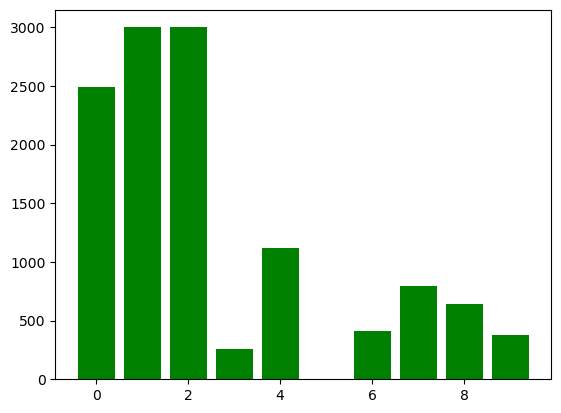

In [18]:
import random

def undersample(label,n):
    img_names = os.listdir(os.path.join(paths['TRAIN_PATH'],str(label)))
    img_names = random.sample(img_names,n)  # Pick n random images to remove
    for image in img_names:
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)
      os.remove(f)

N_IMG_TO_DELETE = [2017,1551]
CLASSES_TO_REDUCE = [1,2]

for i in range(len(CLASSES_TO_REDUCE)):
    undersample(CLASSES_TO_REDUCE[i], N_IMG_TO_DELETE[i])

plotTrainingDistribution()

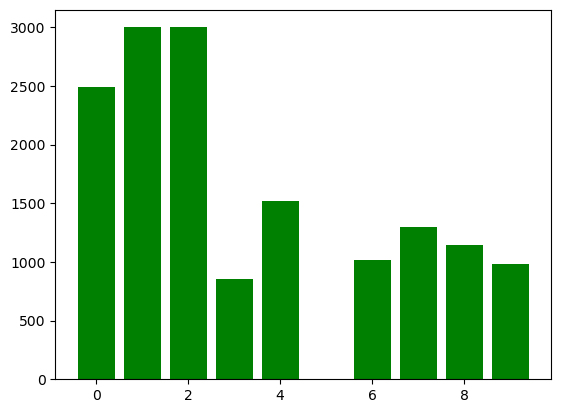

{0: 2488, 1: 3000, 2: 3000, 3: 858, 4: 1523, 6: 1016, 7: 1298, 8: 1146, 9: 981}


In [25]:
import keras.utils as image

CLASSES_TO_AUGMENT = [3,4,6,7,8,9]
N_IMG_TO_AUGMENT = [600,400,600,500,500,600]

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

def augment_images(label,number_images):
    number_images = int(number_images)
    path = os.path.join(paths['TRAIN_PATH'],str(label))
    i = 0
    while i < number_images:
        for f in os.listdir(path):
          img = image.load_img(os.path.join(paths['TRAIN_PATH'],str(label),f), target_size=(69, 69))
          x = image.img_to_array(img)
          x = x.reshape((1,) + x.shape)
          for batch in datagen.flow(x, batch_size=1):
              new_image = image.array_to_img(batch[0])
              new_image.save(os.path.join(paths['TRAIN_PATH'],str(label),"aug_" + str(i) +".jpg"))
              i += 1
              if i > number_images:
                  return
              break

for i in range(len(CLASSES_TO_AUGMENT)):
    augment_images(CLASSES_TO_AUGMENT[i], N_IMG_TO_AUGMENT[i])

plotTrainingDistribution()

In [38]:
# training set image data generator
train_datagen = ImageDataGenerator(rescale=1./255)
train_dir=paths['TRAIN_PATH']
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 20504 images belonging to 9 classes.


In [39]:
# validation set image data generator
val_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented
validation_dir=paths['EVAL_PATH']
validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 3919 images belonging to 9 classes.


# 3. Model creation

In [55]:
# Function used to create the CNN structure used for regression
def create_cnn(width, height, depth, num_classes,filters=(16, 32, 64)):
    inputShape = (height, width, depth)
    model = models.Sequential()
    for (i, f) in enumerate(filters):
        # first CONV layer set appropriately
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same", input_shape=inputShape))
        else:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same"))
        # with padding = same we are able to center convolutional windows around every input tile, in order to have always the same size of the input image
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    # FLATTEN => FC => RELU => BN => DROPOUT
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Dense(num_classes, activation="softmax"))
    return model

model = create_cnn(input_width, input_height, 3, 9, (16,32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 69, 69, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 34, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9248)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [56]:
# compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# 4. Model training

In [42]:
number_training = 0
for i in range(10):
      if i == 5:
        continue
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_training += n_images

number_eval = 0
for i in range(10):
    if i == 5:
        continue
    path = os.path.join(paths['EVAL_PATH'],str(i))
    number_eval += len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

In [43]:
history = model.fit(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

Epoch 1/100
641/641 [==============================] - 126s 188ms/step - loss: 1.8096 - precision: 0.3101 - recall: 0.0262 - acc: 0.3234 - val_loss: 1.5057 - val_precision: 0.5645 - val_recall: 0.0503 - val_acc: 0.4218
Epoch 2/100
641/641 [==============================] - 102s 158ms/step - loss: 1.4535 - precision: 0.6965 - recall: 0.1287 - acc: 0.4432 - val_loss: 1.3165 - val_precision: 0.6606 - val_recall: 0.1728 - val_acc: 0.4680
Epoch 3/100
641/641 [==============================] - 103s 161ms/step - loss: 1.3108 - precision: 0.6957 - recall: 0.2225 - acc: 0.4905 - val_loss: 1.2044 - val_precision: 0.6497 - val_recall: 0.3401 - val_acc: 0.5119
Epoch 4/100
641/641 [==============================] - 101s 157ms/step - loss: 1.2259 - precision: 0.7122 - recall: 0.2939 - acc: 0.5294 - val_loss: 1.1966 - val_precision: 0.6949 - val_recall: 0.2640 - val_acc: 0.5336
Epoch 5/100
641/641 [==============================] - 103s 161ms/step - loss: 1.1679 - precision: 0.7158 - recall: 0.3384 -

# 5. Visualization

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

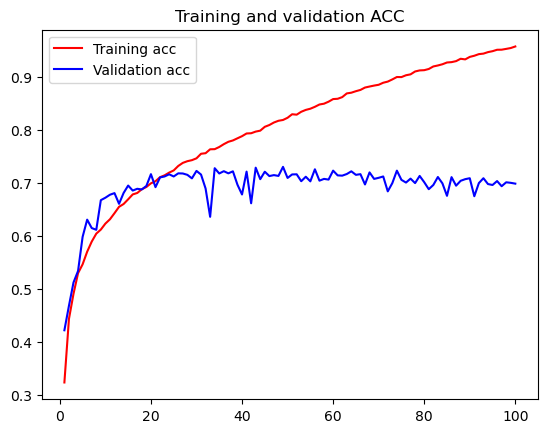

<Figure size 640x480 with 0 Axes>

In [45]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

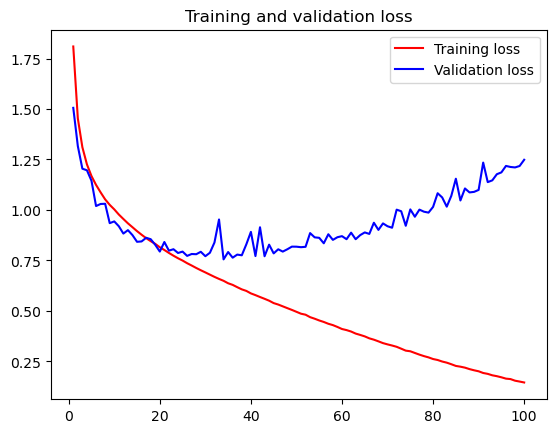

In [46]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

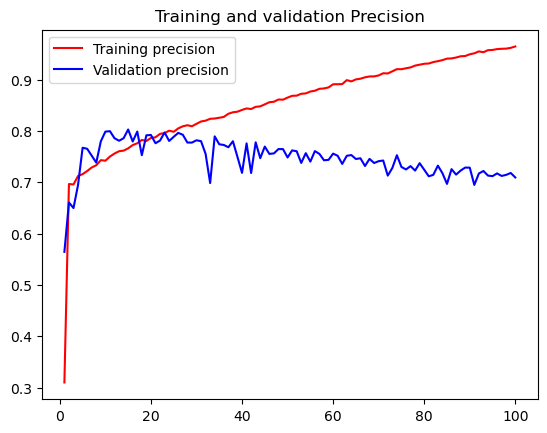

<Figure size 640x480 with 0 Axes>

In [49]:
precision = history.history['precision']
val_precision = history.history['val_precision']
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation Precision')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

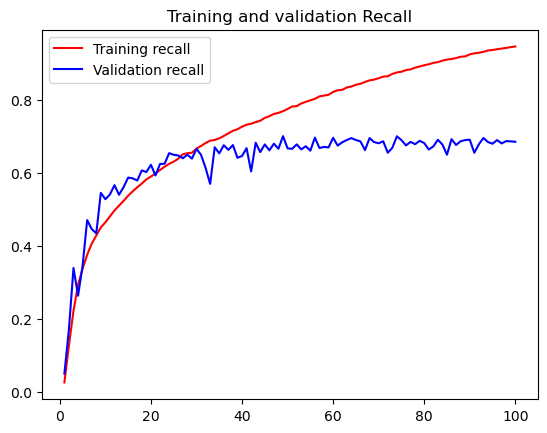

<Figure size 640x480 with 0 Axes>

In [50]:
recall = history.history['recall']
val_recall = history.history['val_recall']
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation Recall')
plt.legend()
plt.figure()

In [ ]:
# smooth curves if they look noisy
# replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# display average, the model may improve even if not reflected

# 6. Early stopping

In [52]:
import keras
import os

callbacks_list = [
        # interrupts training when accuracy has stopped improving accuracy on the validation set for at least 3+1=4 epochs
        keras.callbacks.EarlyStopping(
            monitor='acc', # should be part of the metrics specific during compilation
            patience=10,
        ),
        # save the current weights after every epoch
        #keras.callbacks.ModelCheckpoint(
        #    filepath=os.path.join(paths['MODELS'],'CNN_baseline.h5'),
        #    monitor='val_loss', # do not overwrite until val_loss is improved
        #    save_best_only=True
        #),
        # monitor the model's validation loss and reduce the LR when the validation loss has stopped improving, effective strategy to escape local minima
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # divides LR by 5 when triggered
            patience=3 # called when stopped improving for 3 epochs
        ),
        #keras.callbacks.TensorBoard(
        #    log_dir=paths['LOG_DIR'],
        #    write_graph=True,
        #    histogram_freq=1 # record activation histograms every 1 epoch
        #)
]

In [69]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=100,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)),
      callbacks=callbacks_list)

Epoch 1/100


/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_29712/2149407120.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


641/641 [==============================] - 98s 153ms/step - loss: 0.8832 - precision: 0.7705 - recall: 0.5450 - acc: 0.6740 - val_loss: 0.8760 - val_precision: 0.7807 - val_recall: 0.5627 - val_acc: 0.6859 - lr: 1.0000e-04
Epoch 2/100
641/641 [==============================] - 89s 139ms/step - loss: 0.8673 - precision: 0.7753 - recall: 0.5564 - acc: 0.6774 - val_loss: 0.9590 - val_precision: 0.7608 - val_recall: 0.5251 - val_acc: 0.6438 - lr: 1.0000e-04
Epoch 3/100
641/641 [==============================] - 100s 156ms/step - loss: 0.8499 - precision: 0.7741 - recall: 0.5658 - acc: 0.6812 - val_loss: 0.9225 - val_precision: 0.7531 - val_recall: 0.5470 - val_acc: 0.6545 - lr: 1.0000e-04
Epoch 4/100
641/641 [==============================] - 96s 150ms/step - loss: 0.8349 - precision: 0.7824 - recall: 0.5773 - acc: 0.6891 - val_loss: 0.8637 - val_precision: 0.7744 - val_recall: 0.5872 - val_acc: 0.6838 - lr: 1.0000e-04
Epoch 5/100
641/641 [==============================] - 99s 155ms/step -

# 7. Model testing

In [75]:
number_test = 0
for i in range(10):
      if i == 5:
        continue
      path = os.path.join(paths['TEST_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_test += n_images

17472.jpg
18225.jpg
7520.jpg
13402.jpg
9519.jpg
5445.jpg
360.jpg
4149.jpg
18386.jpg
17248.jpg
4377.jpg
8565.jpg
16802.jpg
21710.jpg
5915.jpg
18807.jpg
981.jpg
11189.jpg
3343.jpg
19258.jpg
18634.jpg
12331.jpg
6575.jpg
3828.jpg
9487.jpg
2277.jpg
13403.jpg
3747.jpg
15728.jpg
9256.jpg
18032.jpg
13601.jpg
2673.jpg
6359.jpg
13617.jpg
12290.jpg
14187.jpg
4758.jpg
1634.jpg
20034.jpg
21458.jpg
15886.jpg
6749.jpg
4823.jpg
12333.jpg
1556.jpg
7655.jpg
13944.jpg
1580.jpg
1219.jpg
19501.jpg
8956.jpg
1999.jpg
5527.jpg
11363.jpg
10055.jpg
9335.jpg
5269.jpg
15924.jpg
7522.jpg
19663.jpg
174.jpg
13825.jpg
3234.jpg
11011.jpg
5866.jpg
5325.jpg
4985.jpg
20757.jpg
3634.jpg
8749.jpg
12875.jpg
12861.jpg
10086.jpg
14586.jpg
548.jpg
19539.jpg
15471.jpg
21059.jpg
9682.jpg
14020.jpg
13767.jpg
11616.jpg
12860.jpg
18342.jpg
6188.jpg
19100.jpg
8172.jpg
17105.jpg
15289.jpg
3594.jpg
8400.jpg
12255.jpg
12241.jpg
20595.jpg
18787.jpg
11947.jpg
11210.jpg
2461.jpg
4010.jpg
21304.jpg
1829.jpg
6834.jpg
4979.jpg
6997.jpg
7479.

In [96]:
# check errors test set
import os
from PIL import Image
folder_path = paths['TEST_PATH']
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

* Path: workspace/images/balanced/test/9/11049.jpg  **** Path: workspace/images/balanced/test/9/21200.jpg  **** Path: workspace/images/balanced/test/9/5154.jpg  **** Path: workspace/images/balanced/test/9/10423.jpg  **** Path: workspace/images/balanced/test/9/17164.jpg  **** Path: workspace/images/balanced/test/9/14900.jpg  **** Path: workspace/images/balanced/test/9/8648.jpg  **** Path: workspace/images/balanced/test/9/928.jpg  **** Path: workspace/images/balanced/test/9/4446.jpg  **** Path: workspace/images/balanced/test/9/3063.jpg  **** Path: workspace/images/balanced/test/9/20895.jpg  **** Path: workspace/images/balanced/test/9/7986.jpg  **** Path: workspace/images/balanced/test/9/16489.jpg  **** Path: workspace/images/balanced/test/9/1289.jpg  **** Path: workspace/images/balanced/test/9/20689.jpg  **** Path: workspace/images/balanced/test/9/17742.jpg  **** Path: workspace/images/balanced/test/9/16716.jpg  **** Path: workspace/images/balanced/test/9/6568.jpg  **** Path: workspace/i

In [114]:
test_dir=paths['TEST_PATH']
print(test_dir)
test_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical', classes=None, shuffle=False)

workspace/images/balanced/test
Found 2931 images belonging to 9 classes.


In [115]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0','1','2','3','4','6','7','8','9']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_29712/276984597.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)


Confusion Matrix
[[271  55  66   3   7   0  31  23  15]
 [ 60 815  53   0   6   0   8   1   3]
 [ 95  44 663   1   6   0  16   6   4]
 [  2   0   3  24  12   3   0   0   5]
 [  8   0  12   2 172   8   1   0   4]
 [  0   0   0   4  15  60   0   0   0]
 [ 48   6   4   1   0   0  73   6   5]
 [ 46   4   4   0   0   0  35  36   4]
 [ 29   0   3   0   3   0   3   8  26]]
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.58      0.53       471
           1       0.88      0.86      0.87       946
           2       0.82      0.79      0.81       835
           3       0.69      0.49      0.57        49
           4       0.78      0.83      0.80       207
           6       0.85      0.76      0.80        79
           7       0.44      0.51      0.47       143
           8       0.45      0.28      0.34       129
           9       0.39      0.36      0.38        72

    accuracy                           0.73      2931
   macro avg 

 1/92 [..............................] - ETA: 8s

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_29712/2081199222.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, verbose = True)


92/92 [==============================] - 4s 39ms/step
Multiclass roc auc score: 0.7850859605015741


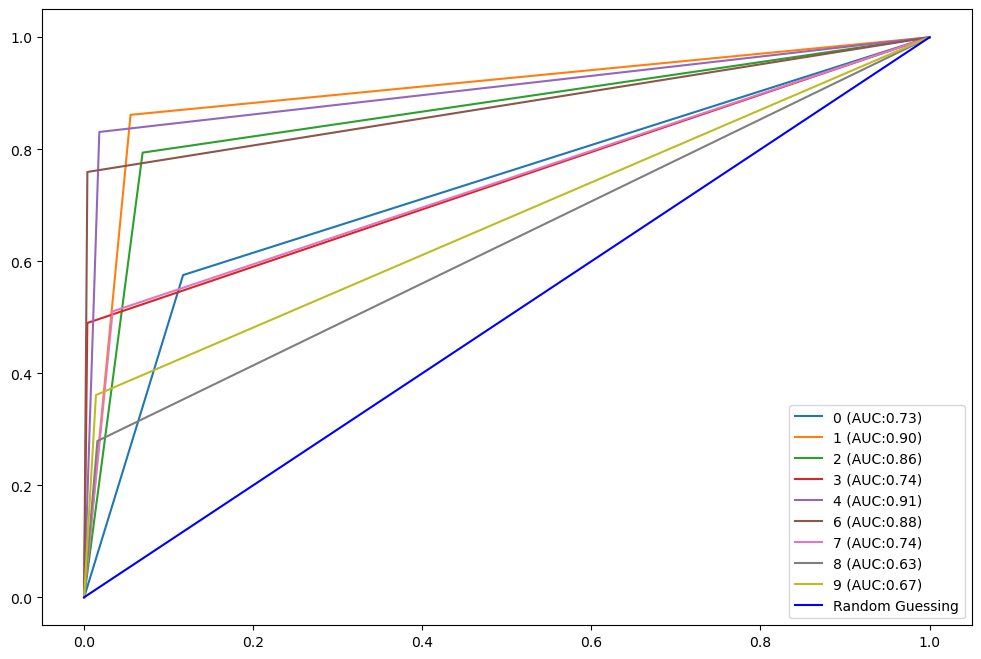

In [110]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)


test_generator.reset()
y_pred = model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print("Multiclass roc auc score:", multiclass_roc_auc_score(test_generator.classes, y_pred))

# 8. Model exportation

In [70]:
model.save("models/CNN_baseline_rebalanced.h5")

# 9. Plot model as graph of layers

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')